In [1]:
import pyautogui
import datetime
import pygetwindow as gw
import win32gui
import sys
import cv2
import os
import time
import numpy as np
sys.path.append('../')
from Segmentation_country.segmentation_country import segmentation_country_class, recognition_class
#from agents.simple_agent_matrix import simple_agent_matrix
from misiones import misiones
from tablero_jugador import Tablero
from Jugadores.jugador import Jugador
from Jugadores.jugadorGrafoOptimizado_2Cambios import JugadorGrafoOptimizado

import math
from matplotlib import pyplot as plt   

In [2]:
def calcular_diferencia_color(color1, color2):
    r1, g1, b1 = color1
    r2, g2, b2 = color2

    diferencia = math.sqrt((r2 - r1)**2 + (g2 - g1)**2 + (b2 - b1)**2)
    return diferencia

def identificar_color(color_a_identificar, color_referencia, umbral):
    diferencia = calcular_diferencia_color(color_a_identificar, color_referencia)
    if diferencia <= umbral:
        return True
    else:
        print(diferencia,umbral)
        return False

In [3]:
def get_chrome_printscreen(filename_save):
    # Nombre de la ventana de Google Chrome
    chrome_window_title = "Google Chrome"

    # Obtener todas las ventanas abiertas
    windows = gw.getAllTitles()

    # Buscar la ventana de Google Chrome en la lista de ventanas
    chrome_window = None
    for window_title in windows:
        if chrome_window_title in window_title:
            chrome_window = gw.getWindowsWithTitle(window_title)[0]
            break

    # Verificar si se encontró la ventana de Chrome
    if chrome_window is None:
        print('nenhuma janela chrome detectada')
        return False

    # Obtener el título de la ventana de Chrome
    chrome_title = win32gui.GetWindowText(chrome_window._hWnd)

    window_title = chrome_title

    # # Obtener la ventana por su título
    window = gw.getWindowsWithTitle(window_title)

    # # Verificar si se encontró la ventana
    if len(window) == 0:
        print(f"No se encontró una ventana con el título '{window_title}'.")

    else:
        # Seleccionar la primera ventana encontrada (puedes ajustar esto si hay varias)
        target_window = window[0]

        # Activar la ventana
        target_window.activate()

        # Capturar la ventana activa
        #
        screenshot = pyautogui.screenshot(region=[target_window.left, target_window.top, target_window.width, target_window.height])

        # Generar un nombre de archivo único basado en la fecha y hora
        timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        filename = f"screenshot_{timestamp}.png"

        # Guardar la captura de pantalla en un archivo
        screenshot.save(filename)

        print(f"Captura de pantalla de la ventana '{window_title}' guardada como {filename}")

        cv_image = cv2.imread(filename)

        crop_image = cv_image[200:900, 200:1300]
        # cv2.imshow("cropped", crop_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        cv2.imwrite(filename_save, crop_image)
        #os.remove(filename)
        return True

def get_player_color(image):

    try:
        player_color = ''
        a2D = image.reshape(-1,image.shape[-1])
        #remove a2D [0,0,0] items
        a2D = a2D[np.all(a2D >= [10,10,10], axis=1)] #removendo black pixels
        #removendo pixels brancos
        a2D = a2D[np.all(a2D<=[240,240,240], axis=1)]
        print('a2D pos remocao black pixels e pixels brancos shape: ', a2D.shape)
        col_range = (256, 256, 256) # generically : a2D.max(0)+1
        a1D = np.ravel_multi_index(a2D.T, col_range)
        bgr_format = np.unravel_index(np.bincount(a1D).argmax(), col_range)
        print('bgr_format: ', bgr_format)
        #colores = ["blue", "red", "green", "purple", "yellow", "black"]
        colores ={"red" : [49,34,185],
                "blue":[181,148,21],
                "green":[53,141,87],
                "yellow":[30,176,218],
                "purple":[116,46,76],
                "black":[56,56,56]} #BLUE GREEN RED
        
        player_color=None
        for key in colores:
            if (identificar_color(bgr_format, colores[key], 95)):
                player_color = key
                break
            else:
                player_color = "blue"
        #time_end = time.time()
        #print('time to get color: ', time_end - time_start)
    except Exception as e:
        player_color = "blue"
        print('error: ', e)
    finally:
        return player_color


def create_matrix_from_masks(masks, ocr: recognition_class):
    #cria matriz de adjacencia
    matrix = []
    territory_army_dict = {}
    for item,mask in masks.items():
        try:
            army = int(ocr.recog_image(mask))
        except:
            army = 1
        if(army is None):
            army = 1
        plyer_color = get_player_color(mask.copy())
        territory_army_dict[item] = [army,plyer_color]

        if (plyer_color is None):
            print('pais: {0} com {1} tropas e cor {2}'.format(item, army, plyer_color))
            cv2.imshow(item, mask)
            cv2.resizeWindow(item, 600,600)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    
    return territory_army_dict

In [4]:
segmentation_prediction = segmentation_country_class("./DA_rodrigo_4000_mobilenetv2.h5")
ocr = recognition_class("text-recognition-resnet-fc-ft-v3-norm.xml","text-recognition-resnet-fc-ft-v3-norm.bin")
screenshot_filepath = "crop_screenshot_completo.jpg"
#CORES  = [  0   ,  1  ,   2   ,    3    ,  4     ,   5  ]
colores = ["blue","red","green","purple","yellow","black"]
#MISAON
cinza_objectivo = 0
Jugador_puc = JugadorGrafoOptimizado("JOGADOR_PUCPR_IA", colores[0], misiones[cinza_objectivo])

mision_desconocida = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
jugador1 = Jugador("1",colores[1],mision_desconocida)
jugador2 = Jugador("2",colores[2],mision_desconocida)
jugador3 = Jugador("3",colores[3],mision_desconocida)
jugador4 = Jugador("4",colores[4],mision_desconocida)
jugador5 = Jugador("5",colores[5],mision_desconocida)

jugadores = [Jugador_puc,jugador1,jugador2,jugador3,jugador4,jugador5]
tablero = Tablero(jugadores)
Jugador_puc.interpretar_mision(misiones[cinza_objectivo])
Jugador_puc.descripcion = misiones[cinza_objectivo].descripcion

layer input shape:  [1,1,32,100]
_____ se ha establecido la mision de conquistar continentonces :  ['Europa', 'Oceanía']
Es neceseario tambien un continente extra : 
_____ se ha establecido la mision de conquistar continentonces :  ['Europa', 'Oceanía']
Es neceseario tambien un continente extra : 


In [8]:
masks = segmentation_prediction.predict_masks(screenshot_filepath)


1/1 [==============================] - 1s 555ms/step


ValueError: zero-size array to reduction operation minimum which has no identity

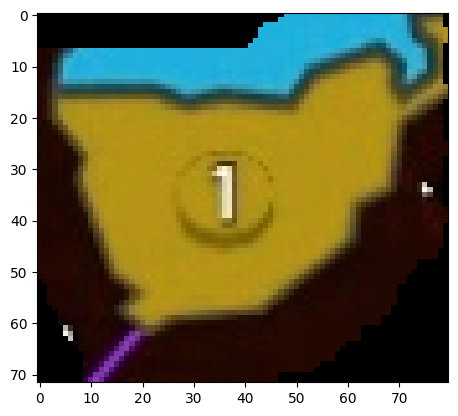

In [14]:
for item,mask in masks.items():
    plt.imshow(mask)